Como nuestra variable objetivo es un valor de 0-1, nuestro enfoque es de tipo regresion.

Se requiere construir un modelo de regresion que permita pronosticar la productividad  de cada empleado con un MAPE menor al 20%

In [31]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [32]:
data=pd.read_csv('garments_worker_productivity.csv')

In [33]:
data.head()

date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0             0.886500  
2                   0           30.5             0.800570  
3                   0           30.5             0.800570  
4                   0           56.0             0.800382

In [34]:
import matplotlib.pyplot as plt
import seaborn as sb
from ydata_profiling import ProfileReport


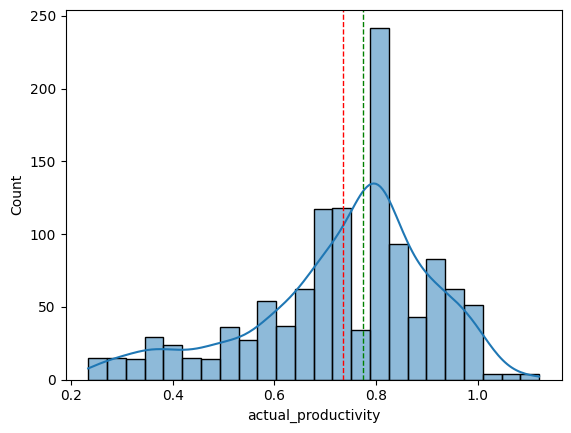

In [35]:
sb.histplot(data=data, x='actual_productivity', kde=True)
plt.axvline(data['actual_productivity'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(data['actual_productivity'].median(), color='green', linestyle='dashed', linewidth=1)
plt.show()

In [36]:
profile=ProfileReport (data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preparacion de datos
- Elimnar la vairbale idlemaen e idletime del conjunto
- Nulos de wip por 0
- Modificar finishing department
- Ajustar las varibales por tipo para modelo

In [37]:
data_mod=data.copy()    
data_mod=data.drop(['idle_time','idle_men'],axis=1)
data_mod['wip'].fillna(0, inplace=True)
data_mod['department'].replace({'finishing ':'finishing'},inplace=True)
data_mod['date']=pd.to_datetime(data_mod['date'],format='%m/%d/%Y')
data_mod['num_day']=[i.day for i in data_mod.date]
data_mod['month']=[i.month for i in data_mod.date]
data_mod['year']=[i.year for i in data_mod.date]
data_mod.drop(['date'],axis=1,inplace=True)
data_mod.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    1197 non-null   float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   no_of_style_change     1197 non-null   int64  
 10  no_of_workers          1197 non-null   float64
 11  actual_productivity    1197 non-null   float64
 12  num_day                1197 non-null   int64  
 13  month                  1197 non-null   int64  
 14  year                   1197 non-null   int64  
dtypes: f

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

## En regresion es buena idea colocar en el endocer la variable objetivo

In [39]:
num_col=data_mod.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_col=data_mod.select_dtypes(include=['object']).columns.to_list()

num_transformer= Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transformer= Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor= ColumnTransformer(transformers=[('num', num_transformer, num_col),
                                            ('cat', cat_transformer, cat_col)],
                                            remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['team', 'targeted_productivity', 'smv', 'wip',
                                  'over_time', 'incentive',
                                  'no_of_style_change', 'no_of_workers',
                                  'actual_productivity', 'num_day', 'month',
                                  'year']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['quarter', 'department', 'day'])])

In [40]:
data_pre=preprocessor.fit_transform(data_mod)
cod_cat=preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_col)
labels=np.concatenate([num_col,cod_cat])

data_pro=pd.DataFrame(data_pre, columns=labels)
data_pro.head()

team  targeted_productivity       smv       wip  over_time  incentive  \
0  0.636364               1.000000  0.450252  0.047920   0.273148   0.027222   
1  0.000000               0.931507  0.020132  0.000000   0.037037   0.000000   
2  0.909091               1.000000  0.164731  0.041865   0.141204   0.013889   
3  1.000000               1.000000  0.164731  0.041865   0.141204   0.013889   
4  0.454545               1.000000  0.445219  0.050601   0.074074   0.013889   

   no_of_style_change  no_of_workers  actual_productivity  num_day  ...  \
0                 0.0       0.655172             0.797332      0.0  ...   
1                 0.0       0.068966             0.736180      0.0  ...   
2                 0.0       0.327586             0.639274      0.0  ...   
3                 0.0       0.327586             0.639274      0.0  ...   
4                 0.0       0.620690             0.639062      0.0  ...   

   quarter_Quarter4  quarter_Quarter5  department_finishing  \
0               0.0               0.0                   0.0   
1               0.0               0.0                   1.0   
2               0.0               0.0                   0.0   
3               0.0               0.0                   0.0   
4               0.0               0.0                   0.0   

   department_sweing  day_Monday  day_Saturday  day_Sunday  day_Thursday  \
0                1.0         0.0           0.0         0.0           1.0   
1                0.0         0.0           0.0         0.0           1.0   
2                1.0         0.0           0.0         0.0           1.0   
3                1.0         0.0           0.0         0.0           1.0   
4                1.0         0.0           0.0         0.0           1.0   

   day_Tuesday  day_Wednesday  
0          0.0            0.0  
1          0.0            0.0  
2          0.0            0.0  
3          0.0            0.0  
4          0.0            0.0  

[5 rows x 25 columns]

In [41]:
from sklearn.model_selection import train_test_split
X=data_pro.drop(['actual_productivity'],axis=1)
y=data_pro['actual_productivity']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.7)

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(359, 24) (838, 24) (359,) (838,)


# Modeldao y validacion tecnica

- Regreson lineal
- SVM
- KMEAN
- Decision tree
- Random forest
- Adaptative Boosting
- Gradient Boosting
- Perceptron Multicapa


In [43]:
# Modeldao y validacion tecnica
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error



In [44]:
modelo_1 = LinearRegression()
modelo_2 = SVR()
modelo_3 = KNeighborsRegressor()
modelo_4 = DecisionTreeRegressor()
modelo_5 = RandomForestRegressor()
modelo_6 = AdaBoostRegressor()
modelo_7 = GradientBoostingRegressor()
modelo_8 = MLPRegressor()

R2: 0.22445204672904628
RMSE: 0.17285149774476255
MAE: 0.13019108079463282
MAPE: 2241256152793.1753


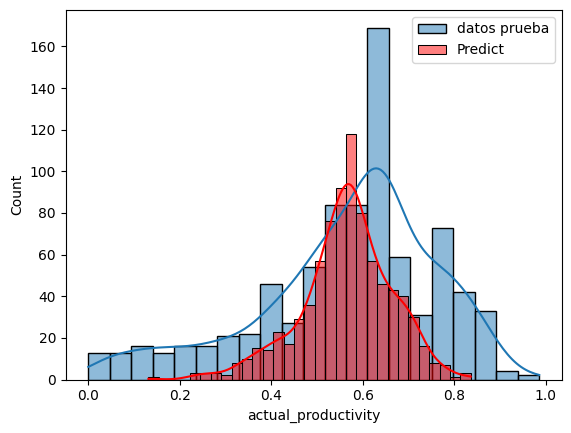

In [45]:
modelo_1.fit(X_train, y_train)
predict_1=modelo_1.predict(X_test)
y_test_des= y_test * (np.max(y) - np.min(y)) + np.min(y)
predict_1_des= predict_1 * (np.max(y) - np.min(y)) + np.min(y)


r2_1=r2_score(y_test_des, predict_1_des)
rmse_1=mean_squared_error(y_test_des, predict_1_des, squared=False)
mae_1=mean_absolute_error(y_test_des, predict_1_des)
mape_1=mean_absolute_percentage_error(y_test_des, predict_1_des)

print('R2:', r2_1)
print('RMSE:', rmse_1)
print('MAE:', mae_1)
print('MAPE:', mape_1)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_1_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Maquina de soporte vectorial

In [46]:
# Busqueda de hiperparametros

hiper_grid= {'C':[0,0.0001,0.001,0.01,0.1,1,10,100],
             'kernel':['linear','poly','rbf','sigmoid'],
                'degree':[2,3,4,6]}
regressor= GridSearchCV(modelo_2, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

C  degree   kernel    Ajuste
80  1.0       2   linear  0.147898
84  1.0       3   linear  0.147898
92  1.0       6   linear  0.147898
88  1.0       4   linear  0.147898
72  0.1       4   linear  0.123784
..  ...     ...      ...       ...
11  0.0       4  sigmoid       NaN
12  0.0       6   linear       NaN
13  0.0       6     poly       NaN
14  0.0       6      rbf       NaN
15  0.0       6  sigmoid       NaN

[128 rows x 4 columns]

In [47]:
modelo_2_final=regressor.best_estimator_
modelo_2_final

SVR(C=1, degree=2, kernel='linear')

In [48]:
predict_2=modelo_2_final.predict(X_test)
predict_2_des= predict_2 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.22672993941577746
RMSE: 0.1725974665777845
MAE: 0.12580010332104555
MAPE: 2215905257915.757


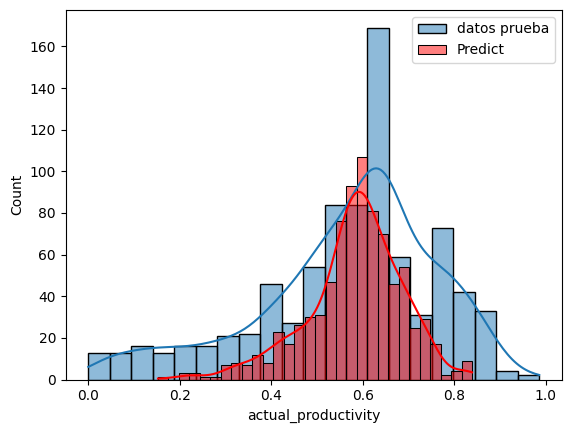

In [49]:

r2_2=r2_score(y_test_des, predict_2_des)
rmse_2=mean_squared_error(y_test_des, predict_2_des, squared=False)
mae_2=mean_absolute_error(y_test_des, predict_2_des)
mape_2=mean_absolute_percentage_error(y_test_des, predict_2_des)

print('R2:', r2_2)
print('RMSE:', rmse_2)
print('MAE:', mae_2)
print('MAPE:', mape_2)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_2_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# K vecinos mas cercanos

In [50]:
# Busqueda de hiperparametros

hiper_grid= {'n_neighbors':[2,3,4,6,8,10,20,100],
             'p':[1,2]}

regressor= GridSearchCV(modelo_3, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)


n_neighbors  p    Ajuste
10           10  1  0.046296
12           20  1  0.043403
14          100  1  0.040247
11           10  2  0.038797
13           20  2  0.028349
15          100  2  0.026561
8             8  1  0.025163
9             8  2  0.012154
6             6  1  0.008630
4             4  1 -0.018355
7             6  2 -0.028149
5             4  2 -0.050431
3             3  2 -0.115462
2             3  1 -0.132356
0             2  1 -0.298979
1             2  2 -0.316313

In [51]:
modelo_3_final=regressor.best_estimator_
modelo_3_final

KNeighborsRegressor(n_neighbors=10, p=1)

In [52]:
predict_3=modelo_3_final.predict(X_test)
predict_3_des= predict_3 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.0597454820072042
RMSE: 0.19032311338488633
MAE: 0.14462820722505798
MAPE: 2515141427045.83


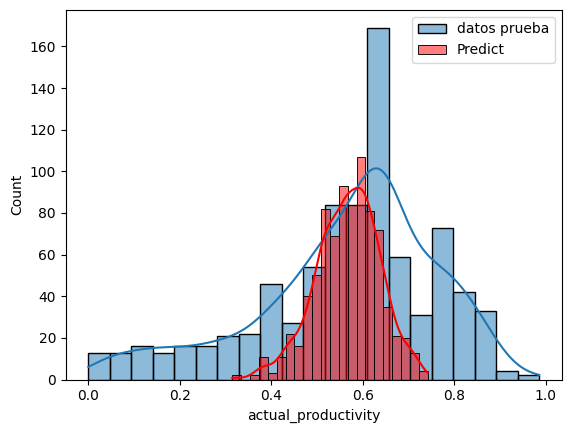

In [53]:

r2_3=r2_score(y_test_des, predict_3_des)
rmse_3=mean_squared_error(y_test_des, predict_3_des, squared=False)
mae_3=mean_absolute_error(y_test_des, predict_3_des)
mape_3=mean_absolute_percentage_error(y_test_des, predict_3_des)

print('R2:', r2_3)
print('RMSE:', rmse_3)
print('MAE:', mae_3)
print('MAPE:', mape_3)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_3_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Arboles de Decision

In [54]:
# Busqueda de hiperparametros

hiper_grid= {'criterion':['squared_error','absolute_error','friedman_mse','poisson'],
             'max_depth':[6,10,15,20,None],
             'max_leaf_nodes':[10,12,15],
             'min_samples_split':[2,6,10]}

regressor= GridSearchCV(modelo_4, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

criterion  max_depth  max_leaf_nodes  min_samples_split    Ajuste
72  absolute_error       20.0              10                  2  0.089833
63  absolute_error       15.0              10                  2  0.089833
64  absolute_error       15.0              10                  6  0.088542
45  absolute_error        6.0              10                  2  0.085038
54  absolute_error       10.0              10                  2  0.085038
..             ...        ...             ...                ...       ...
80  absolute_error       20.0              15                 10 -0.081804
89  absolute_error        NaN              15                 10 -0.081804
62  absolute_error       10.0              15                 10 -0.081804
71  absolute_error       15.0              15                 10 -0.082196
53  absolute_error        6.0              15                 10 -0.083301

[180 rows x 5 columns]

In [55]:
modelo_4_final=regressor.best_estimator_
modelo_4_final

DecisionTreeRegressor(criterion='absolute_error', max_depth=15,
                      max_leaf_nodes=10)

In [56]:
predict_4=modelo_4_final.predict(X_test)
predict_4_des= predict_4 * (np.max(y) - np.min(y)) + np.min(y)

Profundidad del arbol: 4
 Numero de hojas: 10


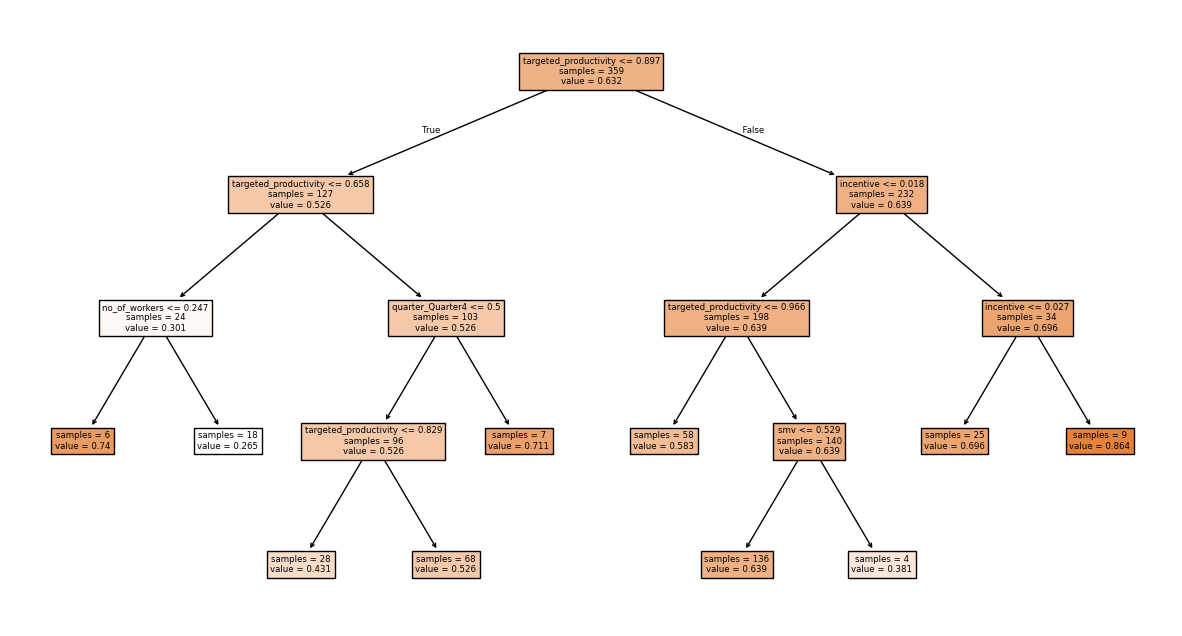

In [57]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(15,8))
print(f'Profundidad del arbol: {modelo_4_final.get_depth()}\n Numero de hojas: {modelo_4_final.get_n_leaves()}')
plot= plot_tree(decision_tree=modelo_4_final,
                feature_names=labels,
               filled=True,
               impurity=False,
               ax=ax)


R2: 0.28292884602054313
RMSE: 0.16620724281752944
MAE: 0.10800878451349581
MAPE: 2828428172576.868


<function matplotlib.pyplot.show(close=None, block=None)>

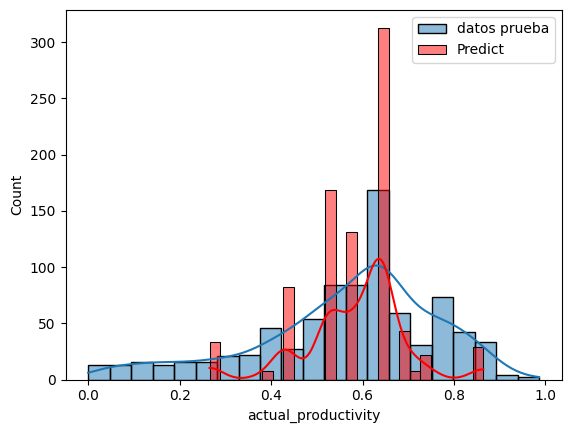

In [58]:

r2_4=r2_score(y_test_des, predict_4_des)
rmse_4=mean_squared_error(y_test_des, predict_4_des, squared=False)
mae_4=mean_absolute_error(y_test_des, predict_4_des)
mape_4=mean_absolute_percentage_error(y_test_des, predict_4_des)

print('R2:', r2_4)
print('RMSE:', rmse_4)
print('MAE:', mae_4)
print('MAPE:', mape_4)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_4_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show

# Random Tree

In [59]:
# Busqueda de hiperparametros

hiper_grid= {'criterion':['squared_error','absolute_error','friedman_mse','poisson'],
             'max_depth':[6,10,15,20,None],
             'n_estimators':[100,200,500,1000],}

regressor= GridSearchCV(modelo_5, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

criterion  max_depth  n_estimators    Ajuste
12   squared_error       20.0           100  0.381533
2    squared_error        6.0           500  0.381336
40    friedman_mse        6.0           100  0.380421
9    squared_error       15.0           200  0.379107
16   squared_error        NaN           100  0.375900
..             ...        ...           ...       ...
72         poisson       20.0           100  0.339001
73         poisson       20.0           200  0.338455
23  absolute_error        6.0          1000  0.336021
68         poisson       15.0           100  0.333111
21  absolute_error        6.0           200  0.330596

[80 rows x 4 columns]

In [60]:
modelo_5_final=regressor.best_estimator_
modelo_5_final

RandomForestRegressor(max_depth=20)

In [61]:
predict_5=modelo_5_final.predict(X_test)
predict_5_des= predict_5 * (np.max(y) - np.min(y)) + np.min(y)

R2: 0.39898489203515175
RMSE: 0.15216385892732687
MAE: 0.09827592042208486
MAPE: 2148547669180.3696


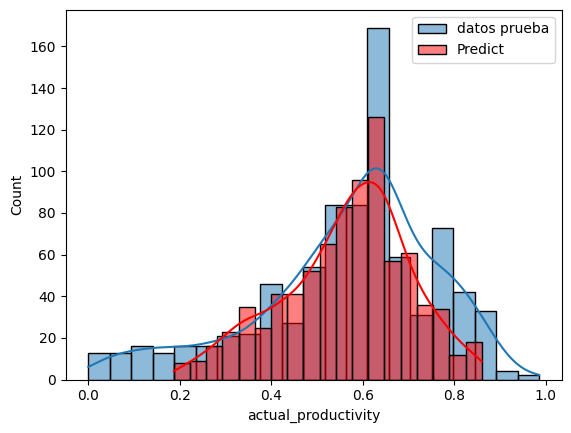

In [62]:

r2_5=r2_score(y_test_des, predict_5_des)
rmse_5=mean_squared_error(y_test_des, predict_5_des, squared=False)
mae_5=mean_absolute_error(y_test_des, predict_5_des)
mape_5=mean_absolute_percentage_error(y_test_des, predict_5_des)

print('R2:', r2_5)
print('RMSE:', rmse_5)
print('MAE:', mae_5)
print('MAPE:', mape_5)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_5_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# AdaBoost

R2: 0.21925575856313828
RMSE: 0.1734295965662879
MAE: 0.1319356702585962
MAPE: 1948361553836.4382


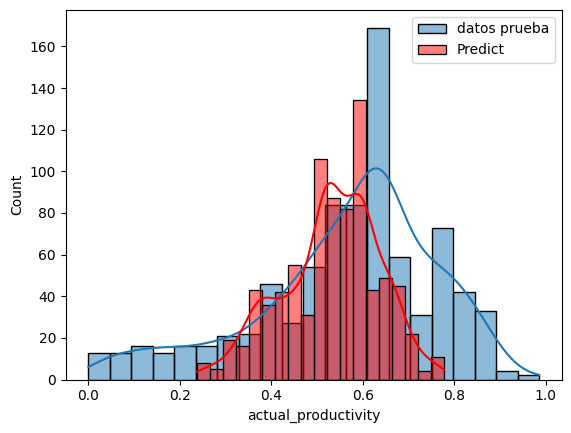

In [63]:
# Busqueda de hiperparametros

hiper_grid= {'n_estimators': [50,100,150,200,250,300,350,400]}

regressor= GridSearchCV(modelo_6, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

modelo_6_final=regressor.best_estimator_


predict_6=modelo_6_final.predict(X_test)
predict_6_des= predict_6 * (np.max(y) - np.min(y)) + np.min(y)


r2_6=r2_score(y_test_des, predict_6_des)
rmse_6=mean_squared_error(y_test_des, predict_6_des, squared=False)
mae_6=mean_absolute_error(y_test_des, predict_6_des)
mape_6=mean_absolute_percentage_error(y_test_des, predict_6_des)

print('R2:', r2_6)
print('RMSE:', rmse_6)
print('MAE:', mae_6)
print('MAPE:', mape_6)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_6_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Gradient

R2: 0.3834035884512046
RMSE: 0.1541236606119423
MAE: 0.10291552343511322
MAPE: 1513431583052.0457


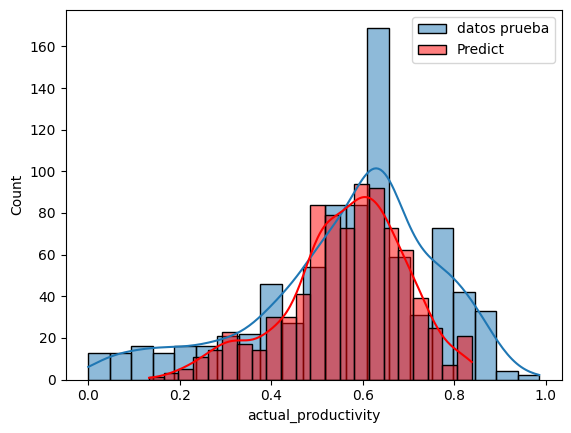

In [64]:
# Busqueda de hiperparametros

hiper_grid= {'n_estimators': [50,100],
             'criterion': ['friedman_mse', 'squared_error'],
             'max_depth': [3,5,7]}

regressor= GridSearchCV(modelo_7, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

modelo_7_final=regressor.best_estimator_


predict_7=modelo_7_final.predict(X_test)
predict_7_des= predict_7 * (np.max(y) - np.min(y)) + np.min(y)


r2_7=r2_score(y_test_des, predict_7_des)
rmse_7=mean_squared_error(y_test_des, predict_7_des, squared=False)
mae_7=mean_absolute_error(y_test_des, predict_7_des)
mape_7=mean_absolute_percentage_error(y_test_des, predict_7_des)

print('R2:', r2_7)
print('RMSE:', rmse_7)
print('MAE:', mae_7)
print('MAPE:', mape_7)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_7_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()

# Perceptron

R2: 0.12812144823126026
RMSE: 0.18327229407002682
MAE: 0.14167417751339703
MAPE: 2574235340382.244


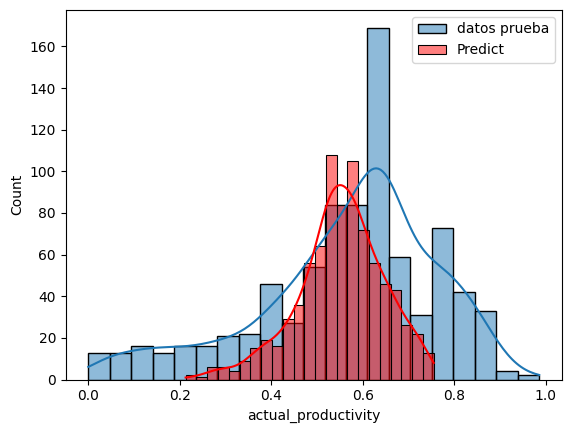

In [65]:
# Busqueda de hiperparametros

hiper_grid= {'hidden_layer_sizes': [(100,),(30,20,10),(20,10),(30,40)],
             'learning_rate_init': [0.001,0.01,0.1,1,10],
             'solver': ['adam', 'sgd'],
             'activation': ['logistic', 'tanh', 'relu'],
             'max_iter': [200,300,400]}

regressor= GridSearchCV(modelo_8, param_grid=hiper_grid, cv=3)
regressor.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(regressor.cv_results_["params"]),
                        pd.DataFrame(regressor.cv_results_["mean_test_score"],
                                    columns=["Ajuste"])],
                                    axis=1)
validation.sort_values("Ajuste", ascending=False)

modelo_8_final=regressor.best_estimator_


predict_8=modelo_8_final.predict(X_test)
predict_8_des= predict_8 * (np.max(y) - np.min(y)) + np.min(y)


r2_8=r2_score(y_test_des, predict_8_des)
rmse_8=mean_squared_error(y_test_des, predict_8_des, squared=False)
mae_8=mean_absolute_error(y_test_des, predict_8_des)
mape_8=mean_absolute_percentage_error(y_test_des, predict_8_des)

print('R2:', r2_8)
print('RMSE:', rmse_8)
print('MAE:', mae_8)
print('MAPE:', mape_8)

sb.histplot(y_test_des, kde=True, label="datos prueba")
sb.histplot(predict_8_des, kde=True, color='red', label='Predict')
plt.legend()
plt.show()